# EDA for Big Data Derby Competition

### Creating paths to diferent folders

In [1]:
import os
from pathlib import Path

# Get current work directory of file (Notebook dir)
NOTEBOOK_DIR=Path(os.path.abspath(os.getcwd()))
# Root path of repo
WORK_DIR=NOTEBOOK_DIR.parent.parent
# Path to Datasets
DATA_DIR=WORK_DIR / 'data'

# Noob printing to check if I did this shit right
print("Notebook dir: ", NOTEBOOK_DIR)
print("Repo dir: ", WORK_DIR)
print("Data dir: ", DATA_DIR)

Notebook dir:  r:\kaggle\big-data-derby-kaggle\notebooks\sainth
Repo dir:  r:\kaggle\big-data-derby-kaggle
Data dir:  r:\kaggle\big-data-derby-kaggle\data


### Loading csv into dataframes

In [2]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

complete_data= pd.read_csv(DATA_DIR / 'nyra_2019_complete.csv', names=['track_id','race_date','race_number','program_number','trakus_index','latitude','longitude','distance_id','course_type','track_condition','run_up_distance','race_type','purse','post_time','weight_carried','jockey','odds','position_at_finish'])
complete_data['race_date'].value_counts()
mix_cd = complete_data.set_index(['track_id', 'race_date', 'race_number', 'program_number'])


C:\Users\santi\AppData\Local\Temp\ipykernel_7708\36363920.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  complete_data= pd.read_csv(DATA_DIR / 'nyra_2019_complete.csv', names=['track_id','race_date','race_number','program_number','trakus_index','latitude','longitude','distance_id','course_type','track_condition','run_up_distance','race_type','purse','post_time','weight_carried','jockey','odds','position_at_finish'])


In [3]:
race_result_df = complete_data.groupby(['track_id', 'race_date','race_number','jockey'])['race_type', 'track_condition','program_number','weight_carried','position_at_finish'].first()
rcd=race_result_df.reset_index()
rcd.head()

C:\Users\santi\AppData\Local\Temp\ipykernel_7708\2552478482.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  race_result_df = complete_data.groupby(['track_id', 'race_date','race_number','jockey'])['race_type', 'track_condition','program_number','weight_carried','position_at_finish'].first()


,track_id,race_date,race_number,jockey,race_type,track_condition,program_number,weight_carried,position_at_finish
0,AQU,2019-01-01,1,Dylan Davis,AOC,MY,1,123,2
1,AQU,2019-01-01,1,Jomar Garcia,AOC,MY,4,123,5
2,AQU,2019-01-01,1,Jose Lezcano,AOC,MY,3,118,4
3,AQU,2019-01-01,1,Junior Alvarado,AOC,MY,2,120,3
4,AQU,2019-01-01,1,Manuel Franco,AOC,MY,5,118,1


## Load Race table df, and check race location distribution


<AxesSubplot:>

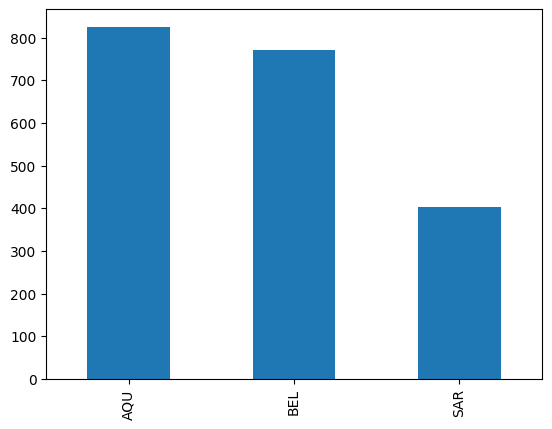

In [4]:
race_data = pd.read_csv(DATA_DIR / 'nyra_race_table.csv')

race_data['track_id'].value_counts().plot(kind='bar')

## Managing data about races... Distance, Velocity and Acceleration

### For now, let's check good jockeys for evaluation, i.e. Who are the best and the worst "W/L" in more races

In [5]:
# Let's check which is the best "winner jockey" to evaluate 
rcd[rcd['position_at_finish']==1].jockey.describe()

count              2003
unique               67
top       Manuel Franco
freq                214
Name: jockey, dtype: object

In [6]:
# Now let's check the same for best "looser jockey" case.
# Since we don't have always the same amount of competitors,
# let's check which is the most common quantity of positions

rcd[rcd['position_at_finish']==6].jockey.describe()


count            1692
unique             94
top       Dylan Davis
freq              147
Name: jockey, dtype: object

### Now that we know that 'Manuel Franco' and 'Dylan Davis' are respectively the "most 1st" and "most sixth", lets try to add distance, velocity and acceleration

#### Considerations: Trackus index starts at 1.

In [7]:
# Random Manuel Franco Race.
rnd_race_df=complete_data[(complete_data.jockey == "Manuel Franco")
& (complete_data.track_id == "AQU")
& (complete_data.race_date == "2019-04-19")
& (complete_data.race_number == 7)
]
rnd_race_df

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,position_at_finish
297,AQU,2019-04-19,7,2,1,40.669548,-73.829641,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2
298,AQU,2019-04-19,7,2,2,40.669553,-73.829638,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2
299,AQU,2019-04-19,7,2,3,40.669559,-73.829635,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2
300,AQU,2019-04-19,7,2,4,40.669567,-73.829632,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2
301,AQU,2019-04-19,7,2,5,40.669578,-73.829627,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,AQU,2019-04-19,7,2,8,40.669629,-73.829606,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2
568,AQU,2019-04-19,7,2,9,40.669651,-73.829596,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2
569,AQU,2019-04-19,7,2,10,40.669675,-73.829586,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2
570,AQU,2019-04-19,7,2,11,40.669701,-73.829574,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2


In [8]:
# Adding "previuos coordinates" to data frame with pandas shift func
# TODO This gives a warning, maybe we should ask how to make this as should be done?
rnd_race_df=rnd_race_df.sort_values(by='trakus_index')
r_shift = rnd_race_df.shift()
r_shift
rnd_race_df['shift_latitude']=r_shift['latitude'].fillna(0)
rnd_race_df['shift_longitude']=r_shift['longitude'].fillna(0)
rnd_race_df

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,position_at_finish,shift_latitude,shift_longitude
297,AQU,2019-04-19,7,2,1,40.669548,-73.829641,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2,0.000000,0.000000
298,AQU,2019-04-19,7,2,2,40.669553,-73.829638,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2,40.669548,-73.829641
299,AQU,2019-04-19,7,2,3,40.669559,-73.829635,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2,40.669553,-73.829638
300,AQU,2019-04-19,7,2,4,40.669567,-73.829632,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2,40.669559,-73.829635
301,AQU,2019-04-19,7,2,5,40.669578,-73.829627,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2,40.669567,-73.829632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,AQU,2019-04-19,7,2,271,40.670832,-73.831894,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2,40.670864,-73.831880
304,AQU,2019-04-19,7,2,272,40.670798,-73.831909,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2,40.670832,-73.831894
305,AQU,2019-04-19,7,2,273,40.670766,-73.831923,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2,40.670798,-73.831909
306,AQU,2019-04-19,7,2,274,40.670733,-73.831938,600,O,FM,58,CLM,62000.0,442,120,Manuel Franco,335,2,40.670766,-73.831923


In [ ]:
from math import radians, cos, sin, asin, sqrt

# Let's def function to apply Haversine formulae
# this snippet of code is extracted from https://www.geeksforgeeks.org/program-distance-two-points-earth/
# by Aarti_Rathi
def haversine_distance(row):
    # Convert from degrees to radians.
    lon1 = radians(row.longitude)
    lon2 = radians(row.shift_longitude)
    lat1 = radians(row.latitude)
    lat2 = radians(row.shift_latitude)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)


rnd_race_df['trakus_distance']=rnd_race_df.apply(haversine_distance, axis='columns')
rnd_race_df['trakus_distance']=rnd_race_df.trakus_distance.map(lambda td: 0 if td>1 else td)

rnd_race_df

In [10]:
rnd_race_df.trakus_distance.sum()


1.3463377664612817

So, we now (at least i think) have the distance the horse have runned. now let's check how many readings were made by trakus for the run-up (58 feet in this example).
We may want to replace iterrows with cumsum

In [11]:
runup_kmd=0.0176784
rand_d=0
tix=0
for index, row in rnd_race_df.iterrows():
    rand_d=rand_d+row.trakus_distance
    if rand_d > runup_kmd:
        ntix=row.trakus_index
        tix = row.trakus_index - 1
        break
print(rand_d, tix)

0.017956602693056302 10


#### Now let's get some more interesting stats, like velocity and acceleration!

In [12]:
def velocity(row):
    km_to_m=row.trakus_distance*1000
    time=0.25
    v_m_s = km_to_m / time
    return v_m_s

def acceleration(row):
    delta_v = row.velocity - row.shift_velocity
    time = 0.25
    a_m_s2= delta_v / time
    return a_m_s2

rnd_race_df['velocity']=rnd_race_df.apply(velocity, axis='columns')
rnd_race_df_vshift=rnd_race_df.shift()
rnd_race_df['shift_velocity']=rnd_race_df_vshift['velocity'].fillna(0)
rnd_race_df['acceleration']=rnd_race_df.apply(acceleration, axis='columns')
rnd_race_df

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,...,weight_carried,jockey,odds,position_at_finish,shift_latitude,shift_longitude,trakus_distance,velocity,shift_velocity,acceleration
297,AQU,2019-04-19,7,2,1,40.669548,-73.829641,600,O,FM,...,120,Manuel Franco,335,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
298,AQU,2019-04-19,7,2,2,40.669553,-73.829638,600,O,FM,...,120,Manuel Franco,335,2,40.669548,-73.829641,0.000626,2.504026,0.000000,10.016104
299,AQU,2019-04-19,7,2,3,40.669559,-73.829635,600,O,FM,...,120,Manuel Franco,335,2,40.669553,-73.829638,0.000683,2.731228,2.504026,0.908808
300,AQU,2019-04-19,7,2,4,40.669567,-73.829632,600,O,FM,...,120,Manuel Franco,335,2,40.669559,-73.829635,0.000968,3.870441,2.731228,4.556852
301,AQU,2019-04-19,7,2,5,40.669578,-73.829627,600,O,FM,...,120,Manuel Franco,335,2,40.669567,-73.829632,0.001237,4.947897,3.870441,4.309826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,AQU,2019-04-19,7,2,271,40.670832,-73.831894,600,O,FM,...,120,Manuel Franco,335,2,40.670864,-73.831880,0.003817,15.268296,15.828894,-2.242391
304,AQU,2019-04-19,7,2,272,40.670798,-73.831909,600,O,FM,...,120,Manuel Franco,335,2,40.670832,-73.831894,0.003933,15.732723,15.268296,1.857709
305,AQU,2019-04-19,7,2,273,40.670766,-73.831923,600,O,FM,...,120,Manuel Franco,335,2,40.670798,-73.831909,0.003817,15.268090,15.732723,-1.858533
306,AQU,2019-04-19,7,2,274,40.670733,-73.831938,600,O,FM,...,120,Manuel Franco,335,2,40.670766,-73.831923,0.003846,15.384420,15.268090,0.465319


In [14]:
rnd_race_df.acceleration.describe()

count    275.000000
mean       0.225184
std        1.619884
min       -3.060138
25%       -0.791694
50%        0.115944
75%        0.874312
max       10.016104
Name: acceleration, dtype: float64